In [5]:
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])

os.environ["PATH"] += ":/usr/local/openeye/bin"
os.environ["OE_LICENSE"] = "/home/fts_g_ucla_edu/Projects/oe_license.txt" 

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent4


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import mols2grid
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import PandasTools
import MDAnalysis as mda
import prolif as plf
from rdkit.Chem.rdFMCS import FindMCS

In [7]:
!reinvent sampling.toml --seed 42

17:45:48 <INFO> Started REINVENT 4.3.5 (C) AstraZeneca 2017, 2023 on 2024-06-28
17:45:48 <INFO> Command line: /home/fts_g_ucla_edu/.conda/envs/reinvent4/bin/reinvent sampling.toml --seed 42
17:45:48 <INFO> User fts_g_ucla_edu on host rips-relay-2024-vm
17:45:48 <INFO> Python version 3.10.14
17:45:48 <INFO> PyTorch version 2.2.1+cu121, git 6c8c5ad5eaf47a62fafbb4a2747198cbffbf1ff0
17:45:48 <INFO> PyTorch compiled with CUDA version 12.1
17:45:48 <INFO> RDKit version 2023.09.5
17:45:48 <INFO> Platform Linux-6.5.0-1018-gcp-x86_64-with-glibc2.35
17:45:48 <INFO> CUDA driver version 550.54.15
17:45:48 <INFO> Number of PyTorch CUDA devices 2
17:45:48 <WARN> 'use_cuda' is deprecated, use 'device' instead
17:45:48 <INFO> Using CUDA device:0 Tesla T4
17:45:48 <INFO> GPU memory: 14814 MiB free, 14917 MiB total
17:45:48 <INFO> Set seed for all random generators to None
17:45:48 <INFO> Writing JSON config file to /home/fts_g_ucla_edu/Projects/wvir/notebook/_sampling.json
17:45:48 <INFO> Starting Samp

In [8]:
df = pd.read_csv("sampling.csv")

In [9]:
mols2grid.display(df)

MolGridWidget()

### Finding and Removing Molcules with Odd Ring Systems

Next, we are going to identify molecules with ring systems which are not chemically stable, as these will probably not be viable drug options. First we use the `RingSystemLookup` class from the `useful_rdkit_utils` toolkit, or `udu`.

In [10]:
ring_system_lookup = uru.RingSystemLookup.default()

Here, we are creating a new column in the dataframe called `ring_systems`. This stores information about the ring system which is retrieved from the RDKit `process_mol` function.

In [11]:
df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)

Next, we create the columns `min_ring` and `min_freq`. These store the ring with the lowest frequency in the molecule (noting that a molecule can have multiple rings) and the specific frequency with which it appears in the ChEMBL databse, respectively.

In [12]:
df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

Now, we only keep that molecules with ring systems which appear more frequently than 100 times in the ChEMBL database. See Pat's Blog for a full discussion.

In [13]:
df_ok = df.query('min_freq > 100').copy()

In [14]:
len(df), len(df_ok)

(460, 234)

We see that only 234 molecules contained reasonable ring systems.

### The Pipeline

Now, we are going to check which of the generated molecules dock to the target protein successfully. First, we use Spruce, which will prepare the protein for docking. *(Q: Did we specify a single target protein yet?)*

In [15]:
!spruce -in data/5s18.pdb -out data/5s18.oedu

          :jGf:               
        :jGDDDDf:             
      ,fDDDGjLDDDf,           Spruce
    ,fDDLt:   :iLDDL;         
  ;fDLt:         :tfDG;       
,jft:   ,ijfffji,   :iff      
     .jGDDDDDDDDDGt.          
    ;GDDGt:''':tDDDG,         
   .DDDG:       :GDDG.        
   ;DDDj         tDDDi        
   ,DDDf         fDDD,         Copyright (C) 2019-2024
    LDDDt.     .fDDDj          Cadence Design Systems, Inc. (Cadence)
    .tDDDDfjtjfDDDGt          
      :ifGDDDDDGfi.            Version: 1.6.0.0
          .:::.                Built:   20240515
  ......................       OEChem version: 4.1.0.0 20240515
  DDDDDDDDDDDDDDDDDDDDDD       Platform: Ubuntu-22.04-g++11.11-x64
  DDDDDDDDDDDDDDDDDDDDDD  




  Licensed for the exclusive use of The Laboratory of Pat Walters.
  Licensed for use only in Relay Therapeutics, Inc.
  License expires on September 5, 2024.


Log written to : spruce_output.log
Run settings written to : spruce_settings.param


Next, we use Omega to generate the conformers from the SMILES strings.

In [16]:
df_ok['Name'] = [f"MOL{i:04d}" for i in range(0,len(df_ok))]

In [17]:
df_ok[["SMILES","Name"]].to_csv("data/analogs_rings_ok.smi",sep=" ",header=None, index=False)

In [18]:
!/usr/local/openeye/bin/omega2 -in data/analogs_rings_ok.smi -out data/analogs_rings_ok.oeb -strictstereo false


          :jGf:             .d8888b. 88d8b.d8b. .d8888b. .d8888b. .d8888b.
        :jGDDDDf:           88'  `88 88'`88'`88 88ooood8 88'  `88 88'  `88
      ,fDDDGjLDDDf,         88.  .88 88  88  88 88.  ... 88.  .88 88.  .88
    ,fDDLt:   :iLDDL;       `88888P' dP  dP  dP `88888P' `8888P88 `88888P8
  ;fDLt:         :tfDG;                                       .88
,jft:   ,ijfffji,   :iff                                  d8888P
     .jGDDDDDDDDDGt.      
    ;GDDGt:''':tDDDG,          Copyright (C) 2004-2024
   .DDDG:       :GDDG.         Cadence Design Systems, Inc. (Cadence)
   ;DDDj         tDDDi    
   ,DDDf         fDDD,         Version: 5.1.0.0
    LDDDt.     .fDDDj          Built:   20240515
    .tDDDDfjtjfDDDGt           OEChem version: 4.1.0.0
      :ifGDDDDDGfi.            Platform: Ubuntu-22.04-g++11.11-x64
          .:::.                
  ......................       
  DDDDDDDDDDDDDDDDDDDDDD       
  DDDDDDDDDDDDDDDDDDDDDD       

Supported run modes:
  Single processor
 

Now we dock the conformers using Hybrid

In [19]:
!/usr/local/openeye/bin/hybrid -receptor data/5s18.oedu -dbase data/analogs_rings_ok.oeb -out data/analogs_rings_ok_docked.sdf

          :jGf:               #     # #     # ######  ######  ### ###### 
        :jGDDDDf:             #     #  #   #  #     # #     #  #  #     #
      ,fDDDGjLDDDf,           #     #   # #   #     # #     #  #  #     #
    ,fDDLt:   :iLDDL;         #######    #    ######  ######   #  #     #
  ;fDLt:         :tfDG;       #     #    #    #     # #   #    #  #     #
,jft:   ,ijfffji,   :iff      #     #    #    #     # #    #   #  #     #
     .jGDDDDDDDDDGt.          #     #    #    ######  #     # ### ###### 
    ;GDDGt:''':tDDDG,         
   .DDDG:       :GDDG.         Copyright (C) 2003-2024
   ;DDDj         tDDDi         Cadence Design Systems, Inc. (Cadence)
   ,DDDf         fDDD,         Version: 4.3.1.0
    LDDDt.     .fDDDj          Build date 20240515
    .tDDDDfjtjfDDDGt           
      :ifGDDDDDGfi.            Platform: Ubuntu-22.04-g++11.11-x64
          .:::.                Supported Run Modes:
  ......................         Single processor
  DDDDDDDDDDDDDDDDDDDDDD  

Now we read the docked molecules into a new dataframe, `dokced_df`.

In [20]:
docked_df = PandasTools.LoadSDF("data/analogs_rings_ok_docked.sdf")
docked_df

Failed to patch pandas - unable to change molecule rendering


,HYBRID receptor title,HYBRID receptor filename,HYBRID Chemgauss4 score,Dock Type,ID,ROMol
0,5S18(A) > WOY(A-201),data/5s18.oedu,-8.660605,Hybrid,MOL0143,<rdkit.Chem.rdchem.Mol object at 0x7652bd92bb50>
1,5S18(A) > WOY(A-201),data/5s18.oedu,-8.585576,Hybrid,MOL0088,<rdkit.Chem.rdchem.Mol object at 0x7652bd92b7d0>
2,5S18(A) > WOY(A-201),data/5s18.oedu,-8.478203,Hybrid,MOL0076,<rdkit.Chem.rdchem.Mol object at 0x7652bd92b530>
3,5S18(A) > WOY(A-201),data/5s18.oedu,-8.383128,Hybrid,MOL0084,<rdkit.Chem.rdchem.Mol object at 0x7652bd92b4c0>
4,5S18(A) > WOY(A-201),data/5s18.oedu,-8.324789,Hybrid,MOL0130,<rdkit.Chem.rdchem.Mol object at 0x7652bd92b450>
...,...,...,...,...,...,...
229,5S18(A) > WOY(A-201),data/5s18.oedu,-4.436922,Hybrid,MOL0083,<rdkit.Chem.rdchem.Mol object at 0x7652bd9950e0>
230,5S18(A) > WOY(A-201),data/5s18.oedu,-4.402618,Hybrid,MOL0232,<rdkit.Chem.rdchem.Mol object at 0x7652bd995150>
231,5S18(A) > WOY(A-201),data/5s18.oedu,-4.324720,Hybrid,MOL0144,<rdkit.Chem.rdchem.Mol object at 0x7652bd9951c0>
232,5S18(A) > WOY(A-201),data/5s18.oedu,-4.300186,Hybrid,MOL0193,<rdkit.Chem.rdchem.Mol object at 0x7652bd995230>


Read the reference fragment *(Q: Is the reference fragment the original molecule from which we generated new analogs?)*

In [21]:
ref_mol = Chem.MolFromMolFile("data/5s18_ligand.sdf")

Calculating the RMSD between each pair of generated molecules

In [22]:
def mcs_rmsd(mol_1, mol_2):
    mcs_res = FindMCS([mol_1, mol_2])
    pat = Chem.MolFromSmarts(mcs_res.smartsString)
    match_1 = mol_1.GetSubstructMatches(pat)
    match_2 = mol_2.GetSubstructMatches(pat)
    min_rmsd = 1e6
    for m1 in match_1:
        for m2 in match_2:
            crd_1 = mol_1.GetConformer(0).GetPositions()[list(m1)]
            crd_2 = mol_2.GetConformer(0).GetPositions()[list(m2)]
            rmsd = np.sqrt((((crd_1 - crd_2)**2).sum()).mean())
            min_rmsd = min(min_rmsd, rmsd)
    return min_rmsd

Calculate the RMSD between the reference fragment and the docked molecules

In [23]:
rmsd_list = [mcs_rmsd(ref_mol,x) for x in docked_df.ROMol.values]

We will store this in a new column of our dataframe of docked molecules, called `rmsd`

In [24]:
docked_df['rmsd'] = rmsd_list

Now we can plot the distribution of the RMSD between the reference fragment and each docked molecule.

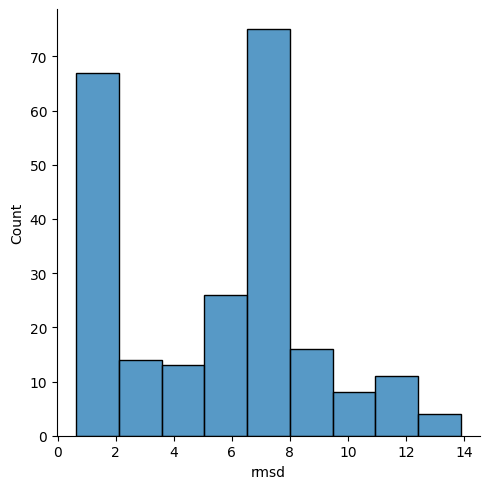

In [25]:
sns.displot(docked_df.rmsd);

We are going to select the molecules that have RMSD <= 2 Agstroms 

In [26]:
df_rmsd_ok = docked_df.query("rmsd <= 2").copy()

Now we write the molcules to a new file

In [27]:
PandasTools.WriteSDF(df_rmsd_ok,"data/analogs_rmsd_ok.sdf")

In [28]:
# Check how many molecules were filtered out
len(docked_df),len(df_rmsd_ok)

(234, 66)

In [29]:
PDB_FILEPATH = "data/5s18_protein.pdb"
SDF_FILEPATH = "data/analogs_rmsd_ok.sdf"

In [30]:
fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(SDF_FILEPATH)
fp.run_from_iterable(suppl,prot,progress=True)
df = fp.to_dataframe()
df.columns = df.columns.droplevel(0)
df

  0%|          | 0/66 [00:00<?, ?it/s]

protein        ALA21.A    ASP22.A     ILE23.A                        \
interaction VdWContact VdWContact Hydrophobic HBAcceptor VdWContact   
Frame                                                                 
0                False       True        True       True       True   
1                False       True        True       True       True   
2                False       True        True       True       True   
3                False       True        True       True       True   
4                False       True        True       True       True   
...                ...        ...         ...        ...        ...   
61               False       True        True       True       True   
62               False       True        True       True       True   
63               False       True        True       True       True   
64               False       True        True       True       True   
65               False      False        True       True       True   

protein         ALA38.A    GLY48.A     VAL49.A                ALA52.A  ...  \
interaction Hydrophobic VdWContact Hydrophobic VdWContact Hydrophobic  ...   
Frame                                                                  ...   
0                 False      False        True       True       False  ...   
1                 False      False        True       True       False  ...   
2                  True      False        True       True       False  ...   
3                 False      False        True      False       False  ...   
4                 False      False        True       True        True  ...   
...                 ...        ...         ...        ...         ...  ...   
61                False      False        True       True       False  ...   
62                False      False        True       True       False  ...   
63                False      False        True       True       False  ...   
64                False      False        True      False        True  ...   
65                False      False        True       True       False  ...   

protein       VAL155.A    PHE156.A                                   \
interaction VdWContact Hydrophobic HBAcceptor PiStacking VdWContact   
Frame                                                                 
0                False        True      False      False       True   
1                False        True      False      False       True   
2                False        True      False      False       True   
3                False        True      False      False       True   
4                False        True      False       True       True   
...                ...         ...        ...        ...        ...   
61               False        True      False      False       True   
62               False        True      False      False       True   
63               False        True      False      False       True   
64               False        True      False       True       True   
65                True        True      False      False       True   

protein        ASP157.A               LEU160.A    DMS202.A             
interaction Hydrophobic VdWContact Hydrophobic Hydrophobic VdWContact  
Frame                                                                  
0                 False      False       False       False      False  
1                  True       True        True        True       True  
2                 False      False       False       False      False  
3                 False      False       False       False      False  
4                 False      False       False       False      False  
...                 ...        ...         ...         ...        ...  
61                False      False       False       False      False  
62                False      False       False       False      False  
63                False      False       False       False      False  
64                False      False       False       

Text(0.5, 54.249999999999986, 'Protein Interaction')

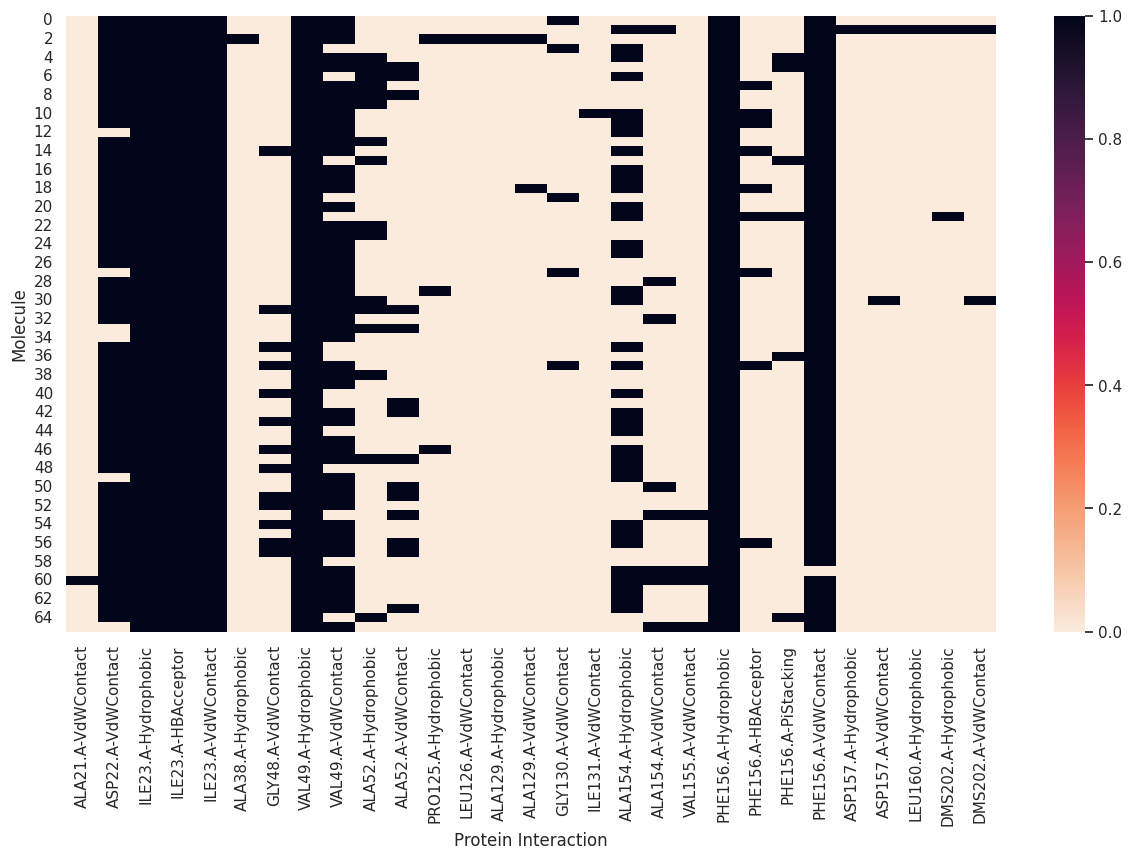

In [31]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(df,cmap=sns.cm.rocket_r)
ax.set_ylabel("Molecule")
ax.set_xlabel("Protein Interaction")

Writing relevant information to a csv, which I will read into a new dataframe in a different notebook for visualizations

In [32]:
mol_ids = df_rmsd_ok['ID'].to_numpy()

bool_list = []

for index, row in df_ok.iterrows():
    if row['Name'] in mol_ids:
        bool_list.append(True)
    else:
        bool_list.append(False)

df_ok['Success'] = bool_list

In [33]:
df_ok.to_csv('dataframe.csv')